In [1]:
import sys
import os
sys.path.append('..')
from lib.path import get_training_data_dir, get_predicted_labeled_water_path, get_displaceable_water_path, get_non_displaceable_water_path
from lib.pdb import filter_atoms_and_create_new_pdb
from data_loader.SingleDataLoader import SingleDataLoader
from data_loader.DoubleDataLoader import DoubleDataLoader
from models.LeNet import LeNet
from models.ResNet import ResNet, ResNet1
from lib.helper import get_latest_checkpoint
from tensorflow.keras.losses import BinaryCrossentropy
from custom_losses.dice import dice_loss, dice_coefficient
from tensorflow.keras.metrics import Recall, Precision, Accuracy, SpecificityAtSensitivity, AUC, F1Score
from sklearn.metrics import confusion_matrix


import numpy as np

2024-07-09 12:56:06.473886: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 12:56:06.476414: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 12:56:06.508526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 12:56:06.508545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 12:56:06.509721: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [18]:
DATA_TYPE1 = 'gr'
# DATA_TYPE2 = 'Protein'
DATA_VOXEL_NUM = 10
CLASSIFYING_RULE = 'WaterClassifyingRuleSurface'
LIGAND_POCKET_DEFINER = 'LigandPocketDefinerOriginal'
LIGAND_VOXEL_NUM = 8
MODEL_NAME = 'ResNet'
TRAINER_NAME = 'aug_train'
training_data_dir1 = get_training_data_dir(DATA_TYPE1, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)
# training_data_dir2 = get_training_data_dir(DATA_TYPE2, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)

data_dir = '../../data'
test_list = os.path.join(data_dir, 'pdb_group/hydrophobic/test_hydrophobic_-1000_pdb')
data_loader = SingleDataLoader(training_data_dir1)
# data_loader = DoubleDataLoader(training_data_dir1, training_data_dir2)
test_data, test_data_label = data_loader.load_data(test_list)

Error processing 4l50: No data found for 4l50
Error processing 4n9c: No data found for 4n9c
Error processing 4l51: No data found for 4l51
Error processing 2xp7: No data found for 2xp7
Error processing 2jkp: No data found for 2jkp
Error processing 2jke: No data found for 2jke
Error processing 5fsy: No data found for 5fsy
Error processing 4u0f: No data found for 4u0f
Error processing 3i4b: No data found for 3i4b
Error processing 2zq0: No data found for 2zq0
Error processing 4jn2: No data found for 4jn2
Error processing 4r0a: No data found for 4r0a
Error processing 5fsx: No data found for 5fsx
Error processing 2bys: No data found for 2bys
Error processing 4l50: No data found for 4l50
Error processing 4n9c: No data found for 4n9c
Error processing 4l51: No data found for 4l51
Error processing 2xp7: No data found for 2xp7
Error processing 2jkp: No data found for 2jkp
Error processing 2jke: No data found for 2jke
Error processing 5fsy: No data found for 5fsy
Error processing 4u0f: No data fou

In [19]:
input_shape = (DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, test_data.shape[-1])
n_base = 8
learning_rate = 1e-4
metrics = ['accuracy', dice_coefficient, Recall(), Precision()]
BN = True

In [20]:
checkpoint_dir = f'../checkpoints/{DATA_TYPE1}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
# checkpoint_dir = f'../checkpoints/{DATA_TYPE1}_{DATA_TYPE2}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
model = ResNet(n_base, input_shape, learning_rate, BinaryCrossentropy(), metrics, BN=BN)
model.load_weights(latest_checkpoint)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 21, 21, 21, 1)]      0         []                            
                                                                                                  
 conv3d_18 (Conv3D)          (None, 21, 21, 21, 8)        224       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 21, 21, 21, 8)        32        ['conv3d_18[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_14 (Activation)  (None, 21, 21, 21, 8)        0         ['batch_normalization_18

In [21]:
prediction = model.predict(test_data)
prediction_values = prediction.reshape(prediction.shape[0])
predicted_label = prediction.round()


377/377 [==============================] - 3s 8ms/step


In [22]:
cm = confusion_matrix(test_data_label, predicted_label)

# 混同行列の要素を取り出す
tn, fp, fn, tp = cm.ravel()

# 結果を表示
print("Confusion Matrix:")
print(cm)
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")
negative_precision = tn / (tn + fn)
print(negative_precision)

Confusion Matrix:
[[4484 1275]
 [1975 4307]]
True Negative (TN): 4484
False Positive (FP): 1275
False Negative (FN): 1975
True Positive (TP): 4307
0.6942251122464778


In [23]:
recall = Recall()
recall.update_state(test_data_label, predicted_label)
recall_value = recall.result().numpy()

precision = Precision()
precision.update_state(test_data_label, predicted_label)
precision_value = precision.result().numpy()

accuracy = Accuracy()
accuracy.update_state(test_data_label, predicted_label)
accuracy_value = accuracy.result().numpy()

specificity = SpecificityAtSensitivity(recall_value)
specificity.update_state(test_data_label, predicted_label)
specificity_value = specificity.result().numpy()

auc = AUC()
auc.update_state(test_data_label, prediction_values)
auc_value = auc.result().numpy()


In [24]:
print({"recall": recall_value, "precision": precision_value, "accuracy": accuracy_value, "specificity": specificity_value, "dice_coefficient": dice_coefficient(test_data_label, predicted_label).numpy(), "auc": auc_value})

{'recall': 0.6856097, 'precision': 0.77158725, 'accuracy': 0.7300889, 'specificity': 0.77860737, 'dice_coefficient': 0.7260851, 'auc': 0.8010812}


In [25]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(test_data_label, prediction_values)

In [203]:
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold_youden = thresholds[optimal_idx]
optimal_threshold_youden

0.39431885

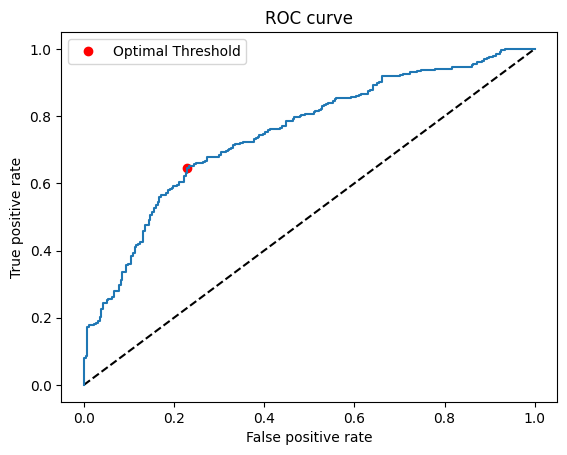

In [204]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label='Optimal Threshold')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [205]:
def custom_threshold(prediction, threshold):
    return (prediction > threshold).astype(int)
optimal_predicted_label = custom_threshold(prediction_values, optimal_threshold_youden)

In [206]:
recall = Recall()
recall.update_state(test_data_label, optimal_predicted_label)
optimal_recall_value = recall.result().numpy()

precision = Precision()
precision.update_state(test_data_label, optimal_predicted_label)
optimal_precision_value = precision.result().numpy()

accuracy = Accuracy()
accuracy.update_state(test_data_label, optimal_predicted_label)
optimal_accuracy_value = accuracy.result().numpy()

specificity = SpecificityAtSensitivity(optimal_recall_value)
specificity.update_state(test_data_label, optimal_predicted_label)
optimal_specificity_value = specificity.result().numpy()

auc = AUC()
auc.update_state(test_data_label, prediction_values)
auc_value = auc.result().numpy()


In [207]:
cm = confusion_matrix(test_data_label, optimal_predicted_label)

# 混同行列の要素を取り出す
tn, fp, fn, tp = cm.ravel()

# 結果を表示
print("Confusion Matrix:")
print(cm)
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")
negative_precision = tn / (tn + fn)
print(negative_precision)

Confusion Matrix:
[[198  59]
 [102 184]]
True Negative (TN): 198
False Positive (FP): 59
False Negative (FN): 102
True Positive (TP): 184
0.66


In [208]:
print({"recall": optimal_recall_value, "precision": optimal_precision_value, "accuracy": optimal_accuracy_value, "specificity": optimal_specificity_value, "dice_coefficient": dice_coefficient(test_data_label, optimal_predicted_label).numpy(), "auc": auc_value})

{'recall': 0.6433566, 'precision': 0.7572017, 'accuracy': 0.7034991, 'specificity': 0.770428, 'dice_coefficient': 0.6962264, 'auc': 0.7486055}
